# Transfer Learning with Ada Embeddings
copyright 2024, Denis Rothman, MIT License


The reference [OpenAI Embedding and Clustering Cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb) was modified by Denis Rothman for educational purposes.

**June 1, 2024 update**

In recent versions of pandas (1.3.x onwards), the error_bad_lines parameter has been removed from pd.read_csv(). Instead, you should use the on_bad_lines parameter.

# Installing OpenAI

In [1]:
try:
  import openai
except:
  !pip install --upgrade openai # installed 1.57
  import openai

In [1]:
%pip install --upgrade "httpx<0.28" # httpx-0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.0
    Uninstalling httpx-0.28.0:
      Successfully uninstalled httpx-0.28.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
f = open("drive/MyDrive/files/api_key.txt", "r")
API_KEY=f.readline()
f.close()

In [5]:
import os
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

# Installing tiktoken

In [6]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.1 MB/s eta 0:00:00


# Installing Kaggle

In [7]:
import json
with open(os.path.expanduser("drive/MyDrive/files/kaggle.json"), "r") as f:
    kaggle_credentials = json.load(f)

kaggle_username = kaggle_credentials["username"]
kaggle_key = kaggle_credentials["key"]

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

In [8]:
try:
  import kaggle
except:
  !pip install kaggle
  import kaggle

In [9]:
kaggle.api.authenticate()

# 1.The Amazon Fine Food Reviews Dataset

## 1.1. Download the dataset


### Amazon Fine Food Reviews

https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews


In [42]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
import zipfile

zip_file_path = '/content/amazon-fine-food-reviews.zip'
csv_file_name = 'Reviews.csv'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name)

##  1.2. Data preparation

In [44]:
# imports
import pandas as pd
import tiktoken

In [45]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this is the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [46]:
# load & inspect dataset
input_datapath = "/content/Reviews.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(10)

,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...
3,1219017600,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...,"Title: ""Delight"" says it all; Content: This is..."
4,1307923200,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...,Title: Cough Medicine; Content: If you are loo...
5,1350777600,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy,Great taffy at a great price. There was a wid...,Title: Great taffy; Content: Great taffy at a ...
6,1342051200,B006K2ZZ7K,ADT0SRK1MGOEU,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,Title: Nice Taffy; Content: I got a wild hair ...
7,1340150400,B006K2ZZ7K,A1SP2KVKFXXRU1,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,Title: Great! Just as good as the expensive b...
8,1336003200,B006K2ZZ7K,A3JRGQVEQN31IQ,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,"Title: Wonderful, tasty taffy; Content: This t..."
9,1322006400,B000E7L2R4,A1MZYO9TZK0BBI,5,Yay Barley,Right now I'm mostly just sprouting this so my...,Title: Yay Barley; Content: Right now I'm most...


In [47]:
## get_embedding function to replace openai's import -- written with help from gpt4o-mini ##

import requests
import os

def get_embedding(text_string):
    # Get the OpenAI API key from environment variable
    api_key = os.getenv("OPENAI_API_KEY")

    if api_key is None:
        raise ValueError("Please set the OPENAI_API_KEY environment variable.")

    # Set the API endpoint
    url = "https://api.openai.com/v1/embeddings"

    # Set the headers for the request
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    # Set the data payload for the request
    data = {
        "input": text_string,
        "model": "text-embedding-ada-002" # embedding_model
    }

    # Make the POST request to the OpenAI API
    response = requests.post(url, headers=headers, json=data)

    # Check for successful response
    if response.status_code == 200:
        data = json.loads(response.text)
        return data['data'][0]['embedding']
    else:
        raise Exception(f"Error: {response.status_code}, Message: {response.text}")


In [48]:
# sub sample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

<ipython-input-48-03f7096fffed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Time", axis=1, inplace=True)


1000

In [49]:
df.combined.head()

,combined
Id,
284932,Title: where does one start...and stop... wit...
220697,Title: Arrived in pieces; Content: Not pleased...
107908,"Title: It isn't blanc mange, but isn't bad . ...."
107800,Title: These also have SALT and it's not sea s...
205313,Title: Happy with the product; Content: My dog...


# 2.Running Ada embeddings and saved for future reuse

In [52]:
# Ensure you have your API key set in your environment per the README: https://github.com/openai/openai-python#usage

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x))
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [53]:
df.embedding.head()

,embedding
Id,
284932,"[0.0070034084, -0.027408825, 0.010529168, -0.0..."
220697,"[-0.02361912, -0.011889805, 0.00044177182, -0...."
107908,"[0.00020324656, 0.005294406, 0.0025072629, 0.0..."
107800,"[0.010425282, -0.0134039335, 0.0042622155, -0...."
205313,"[0.015307778, -0.0039019187, 0.017341862, -0.0..."


## Save the embeddings to Google Drive or another location

In [67]:
#f = open("drive/MyDrive/files/api_key.txt", "r")
!cp /content/fine_food_reviews_with_embeddings_1k.csv drive/MyDrive/fine_food_reviews_with_embeddings_1k.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3.Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

**June 1, 2024 update**

In recent versions of pandas (1.3.x onwards), the error_bad_lines parameter has been removed from pd.read_csv(). Instead, you should use the on_bad_lines parameter. This parameter allows you to specify what to do when bad lines are encountered. Here’s how you can update your code:

```
df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv', on_bad_lines='skip')```


In [10]:
# Retrieve embeddings if saved previously in Drive
#!cp drive/MyDrive/fine_food_reviews_with_embeddings_1k.csv /content/fine_food_reviews_with_embeddings_1k.csv

In [11]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

#df = pd.read_csv(datafile_path)
# read the csv file skipping bad lines
df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv', on_bad_lines='skip')

# count number of lines in the dataframe
df_line_count = len(df)

# count total lines in the csv file
with open('fine_food_reviews_with_embeddings_1k.csv') as f:
    total_line_count = sum(1 for _ in enumerate(f))

# calculate number of bad lines
bad_lines = total_line_count - df_line_count
print(f'Number of bad lines: {bad_lines}')



df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


Number of bad lines: 1


(1000, 1536)

In [12]:
df.head()

,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,284932,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0070034084, -0.027408825, 0.010529168, -0.0..."
1,220697,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.02361912, -0.011889805, 0.00044177182, -0...."
2,107908,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",267,"[0.00020324656, 0.005294406, 0.0025072629, 0.0..."
3,107800,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,239,"[0.010425282, -0.0134039335, 0.0042622155, -0...."
4,205313,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,86,"[0.015307778, -0.0039019187, 0.017341862, -0.0..."


### 3.1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [15]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10,random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


,Score
Cluster,
2,4.104839
0,4.191176
1,4.215613
3,4.308357


### 3.2.Display Clusters with T-SNE

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

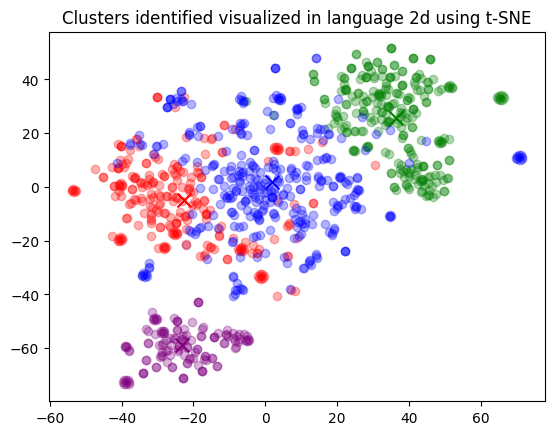

In [14]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

# 4.Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-002 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [18]:
import openai

from openai import OpenAI

client = OpenAI()

# Reading a review that belongs to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )


    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
            }
        ],
        model="gpt-4o-mini", # you may choose a model here
    )


    print(chat_completion.choices[0].message.content.replace("\n", ""))


    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: The common theme in these customer reviews is **pet products, specifically for dogs and cats**. Each review discusses various items related to pet care, including treats, food, and litter. The reviews focus on the effectiveness, convenience, and safety of these products for pets, highlighting experiences with their pets' reactions to the items, the convenience of ordering through subscriptions, and preferences for American-made or specific dietary needs for pets. Overall, the reviews reflect the customers' concerns and experiences regarding the quality and suitability of pet-related products.
5, Dogs love it.:   This is the "all gone" treat after dinner.  It's the only treat that t
2, Triggered strange vomit response to my dog:   I can't deny that these smell amazing- all the fruitables that I order
4, Very convenient:   Before I order anything online, I try to research as much as possible.
5, These are excellent and excellent $$$$ here at Amazon:   This Old Dawg [Chih

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.